In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/SW엔지니어

/content/drive/MyDrive/Colab Notebooks/SW엔지니어


# 목표
- 한국어 분류 데이터셋을 활용한 한국어 토픽 분류 모델 구현해보기
- 데이터 준비부터 미세조정(파인튜닝) 훈련까지의 흐름 경험
- 모델, 토크나이저, FineTuning에 필요한 클래스를 직접 조작하며, 허깅페이스 내부 동작에 대해 좀 더 깊이 있는 실습 진행

In [4]:
# 필요한 라이브러리 가져오기
import torch

In [5]:
# GPU 사용 여부 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:', device)
# 추후 Trainer 클래스 확인용

Using device: cuda


# 1. 데이터셋 로드
- Hugging Face datasets 활용 데이터 로드 해보기

In [6]:
# Hugging Face 데이터 로드용 함수
from datasets import load_dataset
import glob

In [7]:
# !pip install --upgrade datasets fsspec huggingface_hub

### YNAT 데이터셋
- 허깅페이스 링크 : https://huggingface.co/datasets/klue/klue#considerations-for-using-the-data
- 연합뉴스 기사 제목을 7개 주제로 분류
- 레이블 0~6 : 정치/경제/사회/생활,문화/세계/IT,과학/스포츠

In [8]:
# 연합뉴스 기사 제목 데이터셋 로드
raw_datasets = load_dataset('klue', 'ynat')
# klue : 한국어 NLP 전용 종합 벤치마크
# 기계번역, 문장 분류, 개체명 인식 등 8개 태스크 포함

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.17M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/847k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

In [9]:
# DatasetDict : 여러 Dataset을 담는 dict 형태의 클래스 (허깅페이스 제공)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date'],
        num_rows: 9107
    })
})

In [10]:
raw_datasets.keys()

dict_keys(['train', 'validation'])

In [11]:
len(raw_datasets['train'])

45678

In [12]:
len(raw_datasets['validation'])

9107

In [13]:
raw_datasets['train'][0]

{'guid': 'ynat-v1_train_00000',
 'title': '유튜브 내달 2일까지 크리에이터 지원 공간 운영',
 'label': 3,
 'url': 'https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947',
 'date': '2016.06.30. 오전 10:36'}

In [14]:
# DataFrame으로 확인
raw_datasets['train'].to_pandas()

,guid,title,label,url,date
0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.05.08. 오전 5:25
2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.15. 오후 12:00
3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D...,2017.02.28. 오전 9:54
4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.04.03. 오전 7:05
...,...,...,...,...,...
45673,ynat-v1_train_45673,사우디 아람코 주요 석유시설·유전 드론 공격에 화재,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.09.14. 오후 4:36
45674,ynat-v1_train_45674,박기원 감독 눈치 보지 말고…비예나 눈치 본 건 아닌데,5,https://sports.news.naver.com/news.nhn?oid=001...,2019.11.03 17:06
45675,ynat-v1_train_45675,아시안게임 첫 경기 앞둔 라건아 인도네시아 팬이라도 ...,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.08.13 17:54
45676,ynat-v1_train_45676,트럼프 미중 무역협상 1단계 합의 서명식 가질 것종합,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.12.25. 오후 4:36


- 업스트림 : 모델이 일반적인 언어 패턴을 배우는 사전학습 과정
- 다운스트림 : 사전 학습 된 모델을 특정 작업에 맞게 조정하는 fine-tuning

Hugging Face의 구성요소
1. Trainer
  - 데이터 전처리부터 학습,평가,저장까지 모든 과정을 한번에 수행하는 API
  - 아래 4가지 주요 구성 요소를 조합해 Fine-tuning 워크플로우를 완성시켜야 함

2. DataCollator
  - 데이터를 배치 단위로 묶어주는 클래스
  - 각 배치의 입력 데이터를 일정한 크기로 맞추기 위해 패딩 처리 등을 수행함

3. Tokenizer
  - 사전 학습 된 모델에 맞는 토큰화 도구
  - => 업스트림 시 동일한 토크나이저를 사용해 입력 데이터를 처리

4. Downstream Task Classes
  - Fine-tuning 대상 모델
  - 사전 학습된 모델을 다양한 NLP 작업에 맞게 활용할 수 있음

5. Training Arguments
  - 학습 과정에서 필요한 하이퍼파라미터들을 설정하는 클래스
  - 학습률, 배치크기, 에포크 수 등 학습 관련 설정값을 관리

## 2. 토크나이저 로딩
- KoELECTRA 모델로 실습 진행 :

In [15]:
# 사전 학습된 모델에 맞는 토크나이저를 자동으로 불러옴
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [16]:
model_name = 'monologg/koelectra-base-v3-discriminator'

In [17]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    clean_up_tokenization_spaces = True   # 토큰화 이후 공백 문자 등을 정리하는 옵션
)

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [18]:
# 뉴스 헤드라인, 문장에 접근
raw_datasets['train'][0]['title']

'유튜브 내달 2일까지 크리에이터 지원 공간 운영'

In [19]:
# 한개 문장(뉴스 제목)에 접근
temp_result = tokenizer(
    raw_datasets['train'][0]['title'],
    truncation = True,                  # 최대 길이가 넘으면 자르기
    max_length = 128                    # 토큰 최대 길이 설정
)

temp_result

{'input_ids': [2, 11468, 11642, 22, 4366, 4149, 4200, 32462, 6310, 6800, 6411, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokenizer.convert_ids_to_tokens(temp_result['input_ids'])

['[CLS]',
 '유튜브',
 '내달',
 '2',
 '##일',
 '##까',
 '##지',
 '크리에이터',
 '지원',
 '공간',
 '운영',
 '[SEP]']

In [21]:
# 토크나이저 함수 정의
def tokenizer_function(example):
  return tokenizer(example['title'], truncation = True, max_length=128)

- 데이터에 토크나이저 적용
- map()
  - 변환 즉시 적용하며, 반환된 결과는 새로운 데이터셋으로 반환됨
  - 토큰화, 라벨 변환 등 데이터 전처리 작업에서 자주 사용

- with_transform()
  - 변환을 등록해 두고, 실제 데이터 접근시 변환을 적용함(스트림형)
  - 학습을 수행할 때 호출하여 변형이 이루어짐
  - 메모리 절약을 위해, 또는 데이터셋을 한 번에 모두 변형할 필요가 있을 때 유용

In [22]:
# 데이터셋에 토크나이저 적용
tokenizer_datasets = raw_datasets.map(tokenizer_function,
                 batched = True)
# 동작 방식 설정. 하나씩이 아닌 여러 개(배치)씩 모아서 'tokenizer_function'에 전달

Map:   0%|          | 0/45678 [00:00<?, ? examples/s]

Map:   0%|          | 0/9107 [00:00<?, ? examples/s]

In [23]:
tokenizer_datasets

DatasetDict({
    train: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9107
    })
})

In [24]:
tokenizer_datasets['train'].features
# 토크나이저 된 datasets에서 label(y값)을 제외한 데이터 추출

{'guid': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'label': ClassLabel(names=['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치'], id=None),
 'url': Value(dtype='string', id=None),
 'date': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [25]:
# 불필요한 컬럼 추출
remove_columns = [ key for key in raw_datasets['train'].features.keys() if key != 'label']
remove_columns

['guid', 'title', 'url', 'date']

In [26]:
# 훈련에 필요한 입력 ('input_ids', 'token_type_ids', 'attention_mask') 과 label 만 남음
tokenizer_datasets_removed = tokenizer_datasets.remove_columns(remove_columns)
tokenizer_datasets_removed

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9107
    })
})

# 3. 모델 불러오기
- Downstream Task Classes 로드 (사전 학습 모델 불러오기)
- 해석하기 쉽게 모델 설정에서 레이블 이름도 등록

In [27]:
# 레이블 명 추출
label_names = tokenizer_datasets_removed['train'].features['label'].names
label_names

['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']

In [28]:
id2label = { i: name for i, name in enumerate(label_names)}     # enumerate : 인덱스와 원소로 이루어진 튜플을 만듦

In [29]:
label2id = { name: i for i, name in enumerate(label_names)}

# 인덱스와 원소, 원소와 인덱스로 이루어진 튜플을 만듦으로써 예측값에 대해 해석하기 쉽게 모델에 반영할 체크용 데이터

In [30]:
# 모델 불러오기
from transformers import AutoModelForSequenceClassification

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels = len(label_names),    # 라벨의 길이 (클래스 수)
)

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# 모델 설정 - 라벨 이름 확인
model.config.id2label, model.config.label2id

({0: 'LABEL_0',
  1: 'LABEL_1',
  2: 'LABEL_2',
  3: 'LABEL_3',
  4: 'LABEL_4',
  5: 'LABEL_5',
  6: 'LABEL_6'},
 {'LABEL_0': 0,
  'LABEL_1': 1,
  'LABEL_2': 2,
  'LABEL_3': 3,
  'LABEL_4': 4,
  'LABEL_5': 5,
  'LABEL_6': 6})

In [33]:
# 모델 설정에 라벨 이름 매핑 업데이트
model.config.id2label = id2label
model.config.label2id = label2id

# 4. Data Collator & 평가지표 함수 정의
- Collator
  - Trainer에게 전달해주는 클래스
  - 이때, Transformer 모델 입력은 길이가 다를 수 있는 시퀀스이므로, 한 배치 내 최대 길이에 맞추어 패딩이 필요

- 평가지표 함수
  - 학습 중 검증 단계에서 계산할 평가지표 함수 정의
  - 정확도, 정밀도, 재현율, F1 score 활용해보기

In [34]:
# 동적으로 배치 내 최대 길이에 맞춰 패딩하여 Trainer에게 전달해주는 클래스
from transformers import DataCollatorWithPadding

In [35]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

# 평가지표 함수를 정의하기 전에, validation set를 활용해서 test
  1). 예측에 사용할 모델 입력 만들기

In [36]:
# 모델을 GPU/CUDA로 이동
model = model.to(device)

model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [38]:
tokenizer_datasets_removed['validation'][0]

{'label': 2,
 'input_ids': [2,
  25,
  4639,
  4005,
  23362,
  18075,
  4034,
  2411,
  4219,
  27,
  4156,
  4172,
  4005,
  6874,
  4164,
  4034,
  3081,
  4880,
  4176,
  3],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [39]:
# 검증셋에서 샘플 가져오기
sample = tokenizer_datasets_removed['validation'][0]
print(sample)

{'label': 2, 'input_ids': [2, 25, 4639, 4005, 23362, 18075, 4034, 2411, 4219, 27, 4156, 4172, 4005, 6874, 4164, 4034, 3081, 4880, 4176, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [40]:
# 문제 데이터 만들기 >> 라벨(정답 데이터) 추출
use_columns = [key for key in tokenizer_datasets_removed['validation'].features.keys() if key!='label']
use_columns

['input_ids', 'token_type_ids', 'attention_mask']

In [41]:
# 1. 처리 된 모델 입력값을 담아 둘 딕셔너리 초기화
inputs = {}

# 2. sample 순회
for key, value in sample.items():
  # 3. 사용할 필드 확인 (use_columns)
  if key in use_columns:
    tensor = torch.tensor(value) # Pytorch의 Tensor로 형변환, Transformer 모델 입력은 Tensor 이어야만 처리 가능
    tensor = tensor.unsqueeze(0) # 차원 추가
    tensor = tensor.to(device)   # GPU로 이동
    inputs[key] = tensor         # 딕셔너리에 추가

inputs

{'input_ids': tensor([[    2,    25,  4639,  4005, 23362, 18075,  4034,  2411,  4219,    27,
           4156,  4172,  4005,  6874,  4164,  4034,  3081,  4880,  4176,     3]],
        device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
        device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0')}

In [42]:
# 정답 레이블도 같은 방식으로 적용(Tensor 변환, gpu 이동)
label = sample['label']
label_label = torch.tensor([label])
label_label = label_label.to(device)
label_label

tensor([2], device='cuda:0')

In [43]:
# 모델 예측
# 추론에 gradient 계산 불필요 > 메모리 절약 차원 계산 X
with torch.no_grad():
  outputs = model(**inputs)

- 2) 평가지표 활용

In [44]:
import numpy as np
# sklearn metrics는 cpu 메모리 사용 및 numpy 배열 선호

In [45]:
# 로짓(logits) 값을 CPU로 가져와 Numpy 배열형태로 변환
logits = outputs.logits.cpu().numpy()
logits

array([[0.02688386, 0.10514949, 0.12556212, 0.03155395, 0.07473636,
        0.00516994, 0.00704751]], dtype=float32)

In [46]:
# 예측 vs 실제 비교
pred = np.argmax(logits)
print('예측값 :', pred, '->', model.config.id2label[pred])
print('실제값 :', label, '->', model.config.id2label[pred])

예측값 : 2 -> 사회
실제값 : 2 -> 사회


In [47]:
# sklearn 평가지표 불러오기
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [48]:
labels = label_label.cpu().numpy()
labels

array([2])

In [49]:
# 단일 예측값을 1차원 array로 변환
preds = np.array([pred])
preds

array([2])

In [49]:
# 정확도 계산
acc = accuracy_score(labels, preds)
acc

In [51]:
# 정밀도, 재현율, f1 계산
prec, rec, f1, _ =precision_recall_fscore_support(
    labels,
    preds,
    average = 'macro',  # 각 클래스별 결과(정밀도 등)를 계산한 뒤, 모든 클래스를 동일한 비중으로 평균냄
                        # 클래스 불균형 상황에도 각 클래스 성능을 동등하게 평가
    zero_division = 0   # 분모가 0이 되는 경우 결과를 0으로 처리
)

prec, rec, f1, _

(1.0, 1.0, 1.0, None)

# Trainer에게 전달할 평가지표 함수 정의

In [68]:
def compute_metrics(eval_pred):       # eval_pred : (logits, labels) 튜플
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=1)   # axis = 1 : 두 번째 축(클래스 차원)에서 최대값의 인덱스를 찾으라는 뜻

  # 정확도
  acc = accuracy_score(labels, preds)

  # 정밀도, 재현율, f1
  prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average ='macro')
  return {"accuracy":acc, "precision ":prec, "recall":rec, 'f1':f1}

### 5. Training Arguments 설정

In [56]:
# 모델이 한번의 학습 과정에서 처리할 데이터 수
batch_size = 64

In [57]:
from transformers import TrainingArguments

In [69]:
training_args = TrainingArguments(
    output_dir = './data/ynat-model',           # 학습 결과(모델 가중치, 체크포인트 등)를 저장할 경로
    num_train_epochs=3,                         # 학습 횟수
    per_device_train_batch_size =  batch_size,  # 학습에 사용될 배치 크기
    per_device_eval_batch_size = batch_size,    # 검증에 사용할 배치 크기
    learning_rate = 5e-5,                       # 학습률 (BERT 계열에서 흔히 쓰는 값)
    eval_strategy = 'epoch',                    # 각 epochs가 끝날 때 검증
    logging_steps= 50,                          # 학습 중간에 로그를 찍는 간격(스탭 수)
    save_strategy = 'epoch',                    # 모델 저장 전략(epochs마다 저장)
    load_best_model_at_end= True,               # 검증 성능이 최고인 체크포인트를 마지막에 불러옴
    metric_for_best_model= 'accuracy',          # 최고 모델 판단에 사용할 메트릭
    push_to_hub= False,                         # 학습 모델을 허깅페이스에 바로 저장할건지? False = 설치
    report_to ='none'                           # W&B 비활성화
)

# 6. Trainer 초기화 & Fine-Tuning
- Trainer 클래스 : 모델 훈련을 간소화해주는 고수준 API
- Training Arguments, 모델, 데이터셋, 데이터 콜레이터, 평가 함수 등을 인자로 받아 내부에서 학습 루프를 관리

In [63]:
from transformers import Trainer

In [70]:
# 학습 객체 생성
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenizer_datasets_removed['train'],
    eval_dataset = tokenizer_datasets_removed['validation'],
    data_collator = data_collator,
    processing_class = tokenizer,
    compute_metrics = compute_metrics
)

In [71]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.213000,0.487015,0.852421,0.856799,0.853376,0.853434
2,0.235900,0.434343,0.859998,0.857988,0.865230,0.860827
3,0.155700,0.483307,0.860876,0.853222,0.867323,0.859952


TrainOutput(global_step=2142, training_loss=0.22347652210908778, metrics={'train_runtime': 632.5786, 'train_samples_per_second': 216.628, 'train_steps_per_second': 3.386, 'total_flos': 1616745095802300.0, 'train_loss': 0.22347652210908778, 'epoch': 3.0})

In [49]:
# global_step : 전체 학습 스텝 수
# train_samples_per_second : 초당 처리한 샘플 수
# train_steps_per_second : 초당 처리한 학습 스텝 수
# total_flos : 학습에 사용된 총 부동소수점 연산량

# 6. 모델 평가 및 성능 분석
- 검증 데이터에 대한 최종 성능을 확인과 함께 혼돈행렬 관측
- trainer.predict로 개별 예측도 가능

In [72]:
# 검증 셋에 대한 최종 평가
metrics = trainer.evaluate()
metrics

{'eval_loss': 0.4833073318004608,
 'eval_accuracy': 0.8608762490392006,
 'eval_precision ': 0.8532216572276212,
 'eval_recall': 0.8673229143461649,
 'eval_f1': 0.8599518046793253,
 'eval_runtime': 12.4828,
 'eval_samples_per_second': 729.561,
 'eval_steps_per_second': 11.456,
 'epoch': 3.0}

- 혼동 행렬(Confusion Matrix)을 통해 어떤 주제에서 오분류가 발생하는지 관측

In [73]:
from sklearn.metrics import confusion_matrix

In [76]:
# 검증 셋으로 예측 수행
pred_results = trainer.predict(tokenizer_datasets_removed['validation'])
pred_results

PredictionOutput(predictions=array([[-0.51222765,  7.2409587 ,  1.4033436 , ..., -1.7063581 ,
        -3.028619  , -2.33136   ],
       [ 2.4884472 , -0.25476342,  5.1239457 , ..., -3.1630094 ,
        -3.2192779 , -1.3121092 ],
       [ 5.970464  , -0.3213714 ,  0.2509898 , ..., -1.2899024 ,
        -1.5969683 , -2.6596465 ],
       ...,
       [-2.2877111 ,  6.8719964 ,  1.5914973 , ..., -1.5693872 ,
        -2.9948995 , -2.010566  ],
       [-1.2058295 , -3.4614375 ,  4.7555885 , ..., -3.413482  ,
        -1.3974988 ,  1.6228762 ],
       [-0.12224373, -2.2251384 ,  6.0691366 , ..., -2.8283193 ,
        -2.624687  , -1.4516565 ]], dtype=float32), label_ids=array([2, 2, 0, ..., 1, 2, 2]), metrics={'test_loss': 0.4833073318004608, 'test_accuracy': 0.8608762490392006, 'test_precision ': 0.8532216572276212, 'test_recall': 0.8673229143461649, 'test_f1': 0.8599518046793253, 'test_runtime': 12.9424, 'test_samples_per_second': 703.656, 'test_steps_per_second': 11.049})

In [77]:
# 실제 레이블(정답) 추출
y_true = pred_results.label_ids
y_true

array([2, 2, 0, ..., 1, 2, 2])

In [78]:
# 예측 레이블 생성
y_pred = np.argmax(pred_results.predictions, axis=1)
y_pred

array([1, 2, 0, ..., 1, 2, 2])

In [82]:
# 혼돈행렬 생성
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 443,   28,   59,   11,    7,    5,    1],
       [  27, 1148,  141,   12,   14,    5,    1],
       [  65,  184, 3160,  133,   34,   22,  103],
       [  15,   22,  123, 1173,   18,   12,    6],
       [  11,   13,   16,   27,  738,   16,   14],
       [   0,    4,    7,    1,    4,  562,    0],
       [   0,    1,   86,    2,   12,    5,  616]])

- 시각화로 혼돈행렬 관측

In [92]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False) # 마이너스 기호가 깨지지 않게

In [85]:
label_names

['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']

/tmp/ipython-input-93-2082066600.py:47: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 여백을 자동으로 조절해 레이블 겹침 방지
/tmp/ipython-input-93-2082066600.py:47: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 여백을 자동으로 조절해 레이블 겹침 방지
/tmp/ipython-input-93-2082066600.py:47: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 여백을 자동으로 조절해 레이블 겹침 방지
/tmp/ipython-input-93-2082066600.py:47: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 여백을 자동으로 조절해 레이블 겹침 방지
/tmp/ipython-input-93-2082066600.py:47: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # 여백을 자동으로 조절해 레이블 겹침 방지
/tmp/ipython-input-93-2082066600.py:47: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

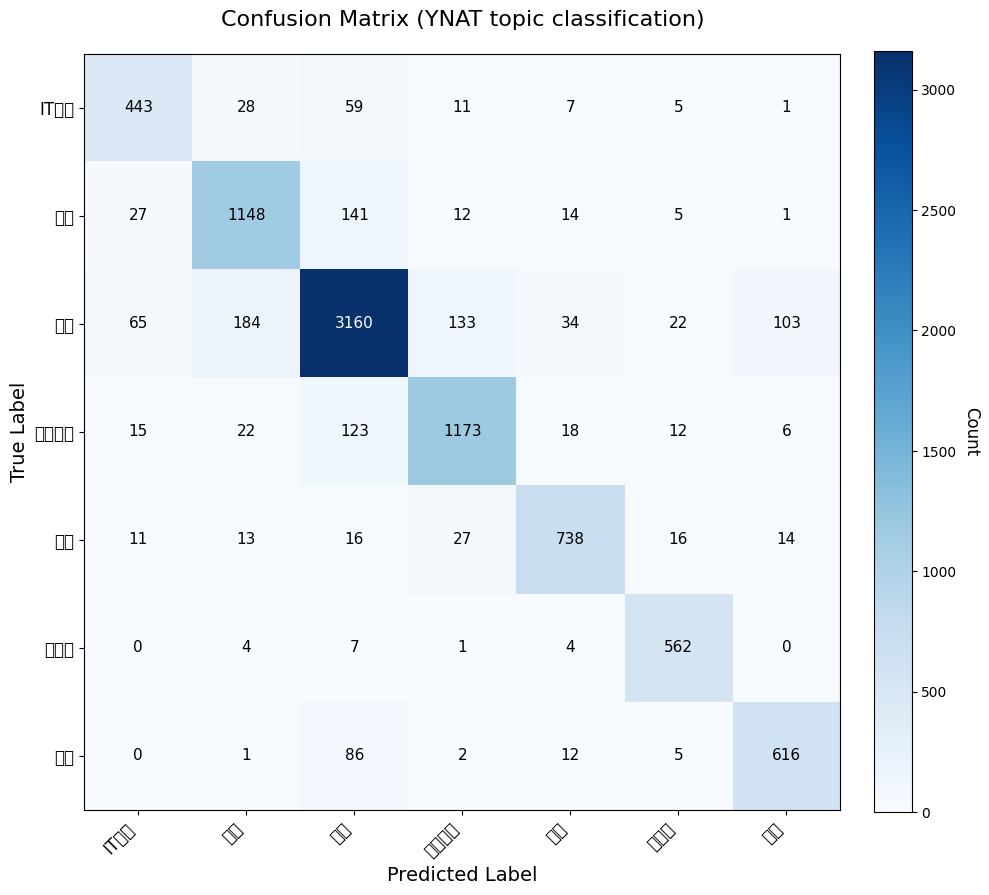

In [93]:
# Figure & Axes(그래프 그릴 영역) 생성
fig, ax = plt.subplots(figsize=(10, 10)) # 전체 그림 크기를 10×10인치로 지정

# 혼동행렬 시각화
# ax.imshow: 2D 배열(혼돈행렬)을 컬러맵으로 시각화
im = ax.imshow(cm, cmap='Blues') # 파란색 계열 색상표 사용

# 컬러바 추가
cbar = fig.colorbar(
    im,               # 시각화된 이미지 객체
    ax = ax,          # 컬러바를 붙일 Axes 지정
    fraction = 0.046, # 컬러바 너비 조절
    pad = 0.04        # 컬러바 간격 조절
)

# 컬러바 축의 레이블 설정
cbar.ax.set_ylabel(
    'Count',        # 레이블 텍스트
    rotation = -90, # 레이블 세로 방향으로 회전
    va = "bottom",  # 수직 정렬을 아래쪽으로
    fontsize = 12   # 글자 크기
)

# 눈금 위치 및 레이블 설정
n = len(label_names)                # 레이블 개수
ax.set_xticks(np.arange(n)) # 눈금(tick) 위치를 0..n-1로 지정
ax.set_yticks(np.arange(n)) # 눈금(tick) 위치를 0..n-1로 지정

# 눈금에 표시할 텍스트 지정
ax.set_xticklabels(label_names, rotation = 45, ha = "right", fontsize = 12) # X축 레이블 45도 회전, 수평 정렬을 오른쪽으로, 글자 크기 12
ax.set_yticklabels(label_names, fontsize = 12)

# 축 제목 및 메인 타이틀
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)
ax.set_title("Confusion Matrix (YNAT topic classification)", fontsize = 16, pad = 20) # 전체 그래프 제목 설정
                                                                                      # pad : 제목과 그래프 사이 여백(px)

# 각 셀에 값 표시
threshold = cm.max() / 2                                     # 셀 색 대비가 어두운지 밝은지 판단 기준
for i in range(n):
    for j in range(n):
        color = "white" if cm[i, j] > threshold else "black" # 셀 값이 threshold 이상이면 흰색 텍스트, 아니면 검정색
        ax.text(j, i, cm[i, j], ha = "center", va = "center", color = color, fontsize = 11) # ha, va: 수평·수직 정렬 방식

# 레이아웃 자동 조정 & 출력
plt.tight_layout() # 여백을 자동으로 조절해 레이블 겹침 방지
plt.show()

# 7. Hugging Face 허브에 모델 업로드하기
- 학습된 모델을 Hugging Face 모델 허브에 업로드하여 공유/배포

In [95]:
!git config --global credential.helper store

In [1]:
model.config._name_or_path # 사전학습 모델 이름(or 경로)

NameError: name 'model' is not defined

In [2]:
# 허깅페이스에 업로드 시 함께 전달할 정보
kwargs = {
    "finetuned_from": model.config._name_or_path, # 이번에 파인튜닝에 활용한 사전학습 모델 이름/경로
    "tasks": ["text-classification"],             # 이 모델이 수행하는 태스크 종류(여러 개일 경우 리스트로)
    "dataset": ["klue-ynat"],                     # 학습·평가에 사용된 데이터셋 이름
    "tags": [                                     # 모델을 설명하는 태그들 (모델 검색 시 키워드 역할)
        "text-classification",
        "KoELECTRA",
        "Korean-NLP",
        "topic-classification",
        "news-classification"
    ],
    "language": ["ko"],                           # 모델이 지원하는 언어 (ISO 코드)
}

NameError: name 'model' is not defined

In [ ]:
trainer.push_to_hub("kimurahose/ko-news-classification", **kwargs)

### 8. 업로드된 모델로 파이프라인 사용

In [3]:
from transformers import pipeline

In [ ]:
my_model = pipeline(task = 'text-classification', model = 'kimurahose/ko-news-classification')

In [ ]:
result = my_model('KIA 트레이드 안 했으면 끔찍했을 뻔… 불안하다 그래도 홀드 1위, 그때 그 선택은 옳았다')
result